In [1]:
import numpy as np
import scipy as sc
import scipy.special as sp
import scipy.stats as ss
import pandas as pd
import math as ma
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import datetime
fontsize_axes = 18.0
fontsize_ticker = 16.0

# Profit and loss of blockchain miners

Let $\pi_{\text{BTC}}$ be the bitcoin price in USD and $\pi_{\text{BTC}}$ be the number of bitcoin as a bounty for finding a new block. The reward is worth

$$b = n_{\text{BTC}}\cdot\pi_{\text{BTC}}$$

In [2]:
# r = requests.get('https://blockchain.info/ticker')
# quote  = dict(r.json())
n_BTC, π_BTC = 6.25, 36303.27
b = n_BTC * π_BTC
print('The BTC price is $' + str(π_BTC) )
print('The reward for finding a block amount to $' + str(b) )

The BTC price is $36303.27
The reward for finding a block amount to $226895.43749999997


The electricity consumption estimated by the Cambridge Bitcoin Electricity Consumption Index [CBECI](https://cbeci.org/) in TWh per year is converted into kWh par hour and denoted by $W$.

In [3]:

W =  95.67 * 10**9 / 365.25 / 24

print('The network consumes ' + str(95.67) + ' tWh per year')  
print('The network consumes ' + str(W) + ' kWh per hour')  

The network consumes 95.67 tWh per year
The network consumes 10913757.70020534 kWh per hour


The time unit is the hour, The network finds 6 new blocks eevry hour. The number of blocks up to time $t$ is a Poisson process $(N_t)_{t\geq0}$ of intensity $\lambda = 6$.

In [4]:
# Intensity of the Poisson process
λ = 6
print('The time unit is the hour, the Poisson process intensity is λ = ' + str(λ))

The time unit is the hour, the Poisson process intensity is λ = 6


The wealth of a miner is given by  

$$
R_t = u-c\cdot t+b\cdot \tilde{N}_t,
$$

where 

- $u$ is the initial reserves
- $c$ is the operational cost of mining
- $b$ the block finding reward
- $\tilde{N}_t$ is a Poisson process of intensity $p\lambda$ the number of blocks found by the considered miner until $t\geq0$

$p\in(0,1/2)$ corresponds to the share of the network hash power owned by the miner. The operational cost is given by

$$
c = p\cdot W\cdot \pi_{\text{W}}, 
$$

where $\pi_{W}$ is the prices ff one kWh of électricité. The net profit condition reads as 

$$
b\cdot\lambda -  W\cdot \pi_{\text{W}}>0
$$

and does not depend on $p$.

In [5]:
print('The net profit condition holds if the cost of electricity is lower than '
      + str(np.around(λ * b / W, decimals = 3))+
      ' when following the protocol')

The net profit condition holds if the cost of electricity is lower than 0.125 when following the protocol


The ruin time is defined by

$$
\tau_u = \inf\{t\geq0\text{ ; }R_t<0\}.
$$

The ruin probability up to time horizon $t\geq0$ is defined as 

$$
\psi(u,t) = \mathbb{P}(\tau_u \leq t).
$$

The ultimate ruin probability

$$
\psi(u) = \mathbb{P}(\tau_u < \infty)
$$

The miner surplus if ruin does not occur is given by
$$
V(u,t) = \mathbb{E}(R_t\mathbb{I}_{\tau_u>t}).
$$

The ruin probability and expected surplus up to an exponential time horizon $T\sim \text{Exp}(t)$ are denoted by

$$
\widehat{\psi}(u,t) = \mathbb{E}[\psi(u,T)],\text{ et } \widehat{V}(u,t) = \mathbb{E}[V(u,T)].
$$

The goal of this notebook is to compare $\psi(u,t)$ and $\widehat{\psi}(u,t)$, and $V(u,t)$ et $\widehat{V}(u,t)$. 

1. For any $u\ge 0$, the infinite-time ruin probability is given by
$$
\psi(u) =e^{-\theta^\ast u},
$$
where $\theta^\ast$ is the positive solution in $\theta$ of the equation 
$$
{c}\,\theta + p\lambda \, (e^{-b\, \theta }-1)=0.
$$
Write a function *ψ(u, b, c, p, λ)* to compute the infinite time horizon ruin probability, evaluate the ruin probability for $u = 10^{6}, p = 0.1$ and $\pi_W = 0.09$. 

**Tips**: Check out the *root_scalar* function in the scipy.optimize library to find $\theta^{\ast}$.

In [6]:
# Function to compute the ultimate ruin probability
def ψ(u, b, c, p, λ):
    def f(x): 
        return(c * x + p * λ * (np.exp(-b*x) - 1))
    theta_star = sc.optimize.root_scalar(f, bracket=[np.log(p * b * λ / c) / b, 100],
                                            method='brentq').root
    return(np.exp(-theta_star * u))
# Evaluation 
u, p, π_W = 1000000, 0.1, 0.09
ψ(u, b, p * W * π_W, p, λ)
# 0.047229557433501254

0.047229557433501254

2. The finite-time ruin probability is given by 
$$
\psi(u,t) = \sum_{n = 0}^{\infty}\frac{u}{u+bn}\;\mathbb{P}\left[\tilde{N}_{\frac{u+bn}{c}} = n\right]\mathbb{I}_{\left\{t>\frac{u+bn}{c}\right\}}. 
$$
Write a function *ψ_t(u, t, b, c, p, λ)* to compute the finite time ruin probability. Evaluate the finite time ruin probability for $t = 24, u = 10^{6}, p = 0.1$ and $\pi_W = 0.09$. 

In [7]:
# Function to compute the ruin probability up to time t
def ψ_t(u, t, b, c, p, λ):
    n = ma.floor((c * t - u) / b)
    return(sum([u / (u + b * k) * ss.poisson.pmf(k, p * λ * (u + b * k) / c) for k in range(n+1)]))
u, p, π_W, t = 1000000, 0.1, 0.09, 24
ψ_t(u, t, b, p * W * π_W, p, λ)
# 0.019827763265097983

0.019827763265097983

3. The finite time ruin probability up to an exponential time horizon is given by 
$$
\widehat{\psi}(u,t) = e^{\rho^\ast u},\text{ For any }u\geq0 
$$
whre $\rho^\ast$ solves the equation
$$
-c\rho + p\lambda(e^{b\rho}-1) = 1/t.
$$
The solution $\rho^\ast$  is given by 
$$
  \rho^{\ast}=-\frac{p\lambda t+1}{ct}
  -\frac{1}{b} \,{\rm W} \left[-\frac{p\lambda
    \,b}{c}\,{e^{-b\,\left(\frac{p\lambda t+1}{ct}\right)}}
  \right],
$$  
where $W(.)$ denotes the Lambert function. Write a function * ψ_T(u, t, b, c, p, λ)* top compute the finite time ruin probability up to an exponential time horizon for $t = 24, u = 10^{6}, p = 0.1$ and $\pi_W = 0.09$.

**Tips**: Check out the function *lambertw* from the scipy.special library. Mind the outcome which is a complex number of which th real part must be extracted!

In [8]:
def ψ_T(u, t, b, c, p, λ):
    
    rho_star = -(p * λ * t +1) / c / t - sp.lambertw(- p * λ *b / c * np.exp(-b*(p * λ * t +1) / c / t))/b
    return(np.exp(np.real(rho_star) * u))

# Evaluation
u, p, π_W, t = 1000000, 0.1, 0.09, 24
ψ_T(u, t, b, p * W * π_W, p, λ)
# 0.015750599579366593

0.015750599475250534

4. Plot on a the same graph the curve $\psi(u), \psi(u,t), $ and $\widehat{\psi}(u,t)$ as function of $u$ for $t = 24, u = 10^{6}, p = 0.1$ and $\pi_W = 0.09$.


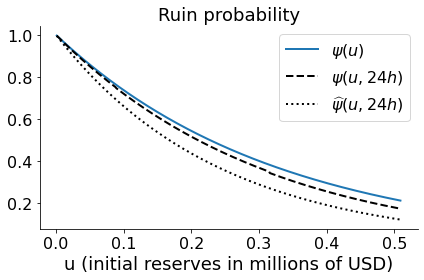

In [14]:
# Time horizon, price of the electricity and  hashpower
t, π_W, p = 24, 0.09, 0.1
# operational cost per hour
c = p * π_W * W
u_vec = np.arange(1000, 510000, 1000) # Sequence of initial reserves
ψ_u_t_vec = [ψ_t(u, t, b, c, p, λ) for u in u_vec]
ψ_u_T_vec = [ψ_T(u, t, b, c, p, λ) for u in u_vec]
ψ_u_vec = [ψ(u, b, c, p, λ) for u in u_vec]
plt.plot(u_vec *1e-6, ψ_u_vec, '-', label = '$\psi(u)$', linewidth=2)
plt.plot(u_vec *1e-6, ψ_u_t_vec, '--', label = '$\psi(u,24h)$', linewidth=2, color ='k')
plt.plot(u_vec*1e-6, ψ_u_T_vec, linestyle = 'dotted', label = '$\widehat{\psi}(u,24h)$', linewidth=2, color ='k')
plt.xlabel('u (initial reserves in millions of USD)', fontsize = fontsize_axes)
plt.title('Ruin probability', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize=fontsize_ticker)

plt.tight_layout()
sns.despine()
plt.savefig('../../Figures/rp_exp_fixed_time.pdf')

5. For any $u\ge 0$, the expected surplus at time $t$ in case ruin has not occurred until then, can be written as 
$$
V(u,t) = \mathbb{E}\left[\left(u+b\tilde{N}_t - ct\right)_+(-1)^{\tilde{N}_t}G_{\tilde{N}_t}\left(0\;\Big\rvert \left\{\frac{u}{ct}\land 1,\ldots, \frac{u+(\tilde{N}_t-1)b}{ct}\land 1\right\}\right) \right],
$$
where $(.)_+$ denotes the positive part, $\land$ stands for the minimum operator and $\left(G_n(\cdot\rvert\{\ldots\}\right)_{n\in\mathbb{N}}$ is the sequence of Abel-Gontcharov polynomials. The latter satisfies the following recursive relationship
$$
G_{n}(x|U)=x^{n}-\sum_{k=0}^{n-1} \binom{n}{k} u_{k+1}^{n-k} G_{k}(x|U), \quad n\geq 1.
$$
Write a function *V_t(u, t, b, c, p, λ, K)* to compute the expected wealth, where $K$ denotes the order of trucation of the involved infinite series. Compute the expected wealth given that ruin did not occur and the expected wealth without ruin considerations (that is $\mathbb{E}(R_t)$) for $t = 24, u = 10^{6}, p = 0.1,\pi_W = 0.09$ and $K = 40$ 

In [19]:
# Function to compute the revenue function over a finite time horizon using Prop 1
def V_t(u, t, b, c, p, λ, K):
    # K is a truncation order for the infinite serie     
    U = [min(1, (u + b * k) / c / t) for k in range(K)]
    V = [max(0, u + k * b - c * t) * (-1) ** k * ss.poisson.pmf(k, p * λ * t) for k in range(K)]
    G_k = [1]
    for k in range(1,K,1):
        G_k.append(
            -sum([
                sp.binom(k,i) * U[i]**(k-i)*G_k[i] 
                for i in range(0,k,1)]))
    return(np.dot(V,G_k))

# Evaluation
u, p, π_W, t, K = 1000000, 0.1, 0.09, 24, 40
c = p * π_W * W
V_t(u, t, b, c, p, λ, K), u - c*t + λ*p*b*t
# (1904119.1856785547, 1909922.6367556476)


(1904119.1856785547, 1909922.6367556476)

6. For any $u\geq0$, The expected surplus given that ruin did not occur up to an exponential time horizon
$$
\widehat{V}(u,t) = u+(p\lambda b-c)t\left(1-e^{\rho^\ast u }\right),
$$
where $\rho^\ast$ is the negative solution of the equation
$$
-c\rho + p\lambda(e^{b\rho}-1) = 1/t.
$$
The solution $\rho^\ast$ is given by 
$$
  \rho^{\ast}=-\frac{p\lambda t+1}{ct}
  -\frac{1}{b} \,{\rm W} \left[-\frac{p\lambda
    \,b}{c}\,{e^{-b\,\left(\frac{p\lambda t+1}{ct}\right)}}
  \right],
 $$  
 where $W(.)$ denotes the Lambert function. Compute the expected wealth given that ruin did not occur up to an exponential time horizon and the expected wealth without ruin considerations (that is $\mathbb{E}(R_T)$) for $t = 24, u = 10^{6}, p = 0.1,$ and $\pi_W = 0.09$

In [24]:
# Function to compute the value function over an exponential time horizon
def V_T(u, t, b, c, p, λ):
    γ = p * λ * b - c
    rho_star = -(p * λ * t +1) / c / t - sp.lambertw(- p * λ *b / c * np.exp(-b*(p * λ * t +1) / c / t))/b
    return(γ * t + u - γ * t * np.exp(np.real(rho_star) * u))

# Evaluation
u, p, π_W, t = 1000000, 0.1, 0.09, 24
c = p * π_W * W
V_T(u, t, b, c, p, λ), u - c*t + λ*p*b*t
# (1895590.8097506454, 1909922.6367556476)

(1895590.8097506454, 1909922.6367556476)

7. Plot the functions $V(u,t)-u,\widehat{V}(u,t)-u$ and $\mathbb{E}(R_t)-u$ as a function of $u$ for for $t = 24, u = 10^{6}, p = 0.1,\pi_W = 0.09$ and $K = 40$

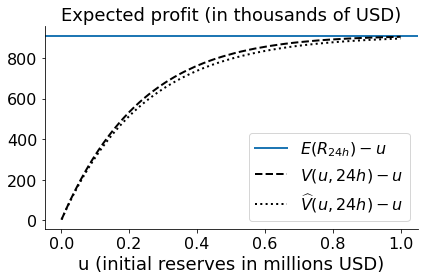

In [29]:
# Time horizon, price of the electricity and  hashpower
t, π_W, p = 24, 0.09, 0.1
c = p * π_W * W
u_vec = np.arange(1000, 1000000, 1000) # Sequence of initial reserves
V_u_t_vec = np.array([V_t(u, t, b, c, p, λ, 40)-u for u in u_vec])/1000
V_u_T_vec = np.array([ V_T(u, t, b, c, p, λ)-u for u in u_vec])/1000
plt.axhline(y = (- c * t + p * λ * b * t)/1000, label = '$E(R_{24h})-u$', linewidth=2)
plt.plot(u_vec*1e-6, V_u_t_vec, label = '$V(u,24h)-u$', linestyle = 'dashed', color = 'k', linewidth=2)
plt.plot(u_vec*1e-6, V_u_T_vec, linestyle = 'dotted', label = '$\widehat{V}(u,24h)-u$', color = 'k', linewidth=2)
plt.xlabel('u (initial reserves in millions USD)', fontsize = fontsize_axes)
plt.title('Expected profit (in thousands of USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize=fontsize_ticker)
sns.despine()
plt.tight_layout()
sns.despine()
plt.savefig('../../Figures/V_exp_fixed_time.pdf')